# Implementing LSTMs using TensorFlow

This notebook walks you through the implementation of an LSTM model to classify news headlines as sarcastic or not_sarcastic. We will analyse the accuracy & loss curves for training and validation sets.

In [1]:
##import the required libraries and APIs
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)

2.8.0


## Downloading the Headlines data


In [2]:
import pandas as pd

data = pd.read_json("./x1.json")
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [3]:
##create arrays to store the headlines and labels
headlines = list(data['headline'])
labels = list(data['is_sarcastic'])

## Data Preparation

In [4]:
##define tokenizing and padding parameters
vocab_size = 10000
max_length = 120
embedding_dim = 32
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000  # define training size(index)

In [5]:
##training set from 0 to training size
training_sentences = headlines[0:training_size]
training_labels = labels[0:training_size]

##testing set from training size to the end
testing_sentences = headlines[training_size:]
testing_labels = labels[training_size:]

In [6]:
##train the tokenizer on training data
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

##create training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

##create test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [7]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

## Define the LSTM model with the following layers:
1. Embedding layer
2. Add two bidirectional LSTM layers with 64 and 32 as number of outputs.
3. Dense layer with 24 nodes
4. Output Dense layer with `sigmoid` activation 

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 32)           320000    
                                                                 
 bidirectional (Bidirectiona  (None, 120, 128)         49664     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 24)                1560      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 412,465
Trainable params: 412,465
Non-trai

In [10]:
num_epochs = 10
history = model.fit(training_padded,
                    training_labels,
                    epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels),
                    verbose=2)

Epoch 1/10
625/625 - 58s - loss: 0.4111 - accuracy: 0.8080 - val_loss: 0.5732 - val_accuracy: 0.5996 - 58s/epoch - 94ms/step
Epoch 2/10
625/625 - 51s - loss: 0.2362 - accuracy: 0.9058 - val_loss: 0.3266 - val_accuracy: 0.8559 - 51s/epoch - 82ms/step
Epoch 3/10
625/625 - 51s - loss: 0.1427 - accuracy: 0.9465 - val_loss: 0.4099 - val_accuracy: 0.8464 - 51s/epoch - 81ms/step
Epoch 4/10
625/625 - 52s - loss: 0.0848 - accuracy: 0.9704 - val_loss: 0.4634 - val_accuracy: 0.8413 - 52s/epoch - 83ms/step
Epoch 5/10
625/625 - 53s - loss: 0.0546 - accuracy: 0.9819 - val_loss: 0.5585 - val_accuracy: 0.8380 - 53s/epoch - 85ms/step
Epoch 6/10
625/625 - 53s - loss: 0.0350 - accuracy: 0.9884 - val_loss: 0.6863 - val_accuracy: 0.8327 - 53s/epoch - 85ms/step
Epoch 7/10
625/625 - 53s - loss: 0.0259 - accuracy: 0.9918 - val_loss: 0.7487 - val_accuracy: 0.8364 - 53s/epoch - 85ms/step
Epoch 8/10
625/625 - 53s - loss: 0.0223 - accuracy: 0.9923 - val_loss: 0.8370 - val_accuracy: 0.8362 - 53s/epoch - 84ms/step


## Visualize accuracy and loss

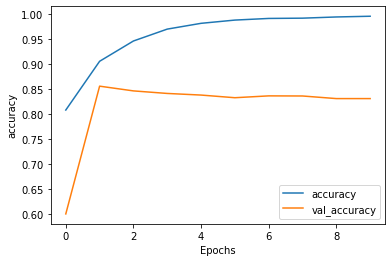

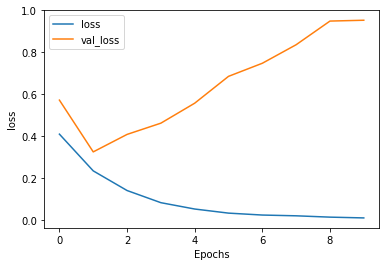

In [11]:
import matplotlib.pyplot as plt


def plot_metrics(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()
  
plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

## Classifying unseen headlines

In [12]:
sentence = ["the girl starting to fear snakes in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[4.1923733e-05]
 [1.2981892e-04]]
